In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Load datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

# Use Close prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

# Normalize using training data only
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)


In [4]:
def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])

    return np.array(x), np.array(y)


seq_length = 60

x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)



In [5]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [6]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

In [7]:
class RNNModel(nn.Module):

    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN Layer
        self.rnn = nn.RNN(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True
        )

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        # Initialize hidden state
        h0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size
        ).to(x.device)

        # RNN forward
        out, _ = self.rnn(x, h0)

        # Take last time step output
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)

        return out


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNModel().to(device)

print("Using device:", device)



Using device: cpu


In [9]:
!pip install torchinfo

from torchinfo import summary

summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [10]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)



In [11]:

train_losses = []

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for inputs, targets in train_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

Epoch [1/30], Loss: 0.069431
Epoch [2/30], Loss: 0.013286
Epoch [3/30], Loss: 0.001260
Epoch [4/30], Loss: 0.000621
Epoch [5/30], Loss: 0.000455
Epoch [6/30], Loss: 0.000404
Epoch [7/30], Loss: 0.000421
Epoch [8/30], Loss: 0.000409
Epoch [9/30], Loss: 0.000379
Epoch [10/30], Loss: 0.000357
Epoch [11/30], Loss: 0.000385
Epoch [12/30], Loss: 0.000343
Epoch [13/30], Loss: 0.000365
Epoch [14/30], Loss: 0.000351
Epoch [15/30], Loss: 0.000393
Epoch [16/30], Loss: 0.000435
Epoch [17/30], Loss: 0.000441
Epoch [18/30], Loss: 0.000332
Epoch [19/30], Loss: 0.000311
Epoch [20/30], Loss: 0.000310
Epoch [21/30], Loss: 0.000311
Epoch [22/30], Loss: 0.000303
Epoch [23/30], Loss: 0.000288
Epoch [24/30], Loss: 0.000310
Epoch [25/30], Loss: 0.000358
Epoch [26/30], Loss: 0.000289
Epoch [27/30], Loss: 0.000273
Epoch [28/30], Loss: 0.000296
Epoch [29/30], Loss: 0.000314
Epoch [30/30], Loss: 0.000274


Name:Kirthick sha R
Register Number:  212224230124   


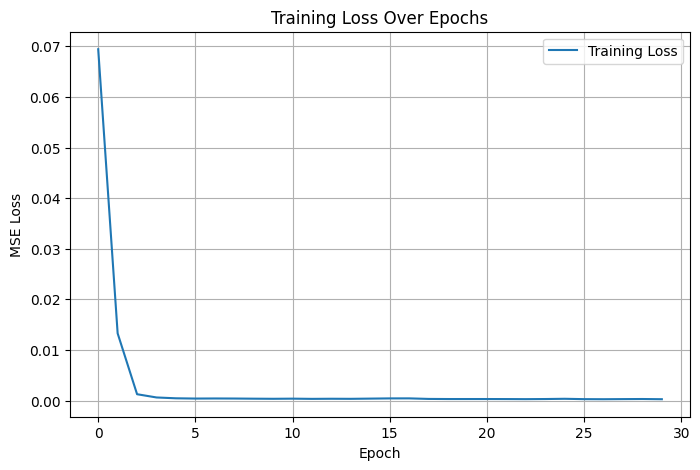

In [12]:
print('Name:Kirthick sha R')
print('Register Number:  212224230124   ')

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [13]:
model.eval()

with torch.no_grad():

    predicted = model(x_test_tensor.to(device))
    predicted = predicted.cpu().numpy()

    actual = y_test_tensor.cpu().numpy()

In [14]:
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

Name:  kirthick sha R 
Register Number:  212224230124  


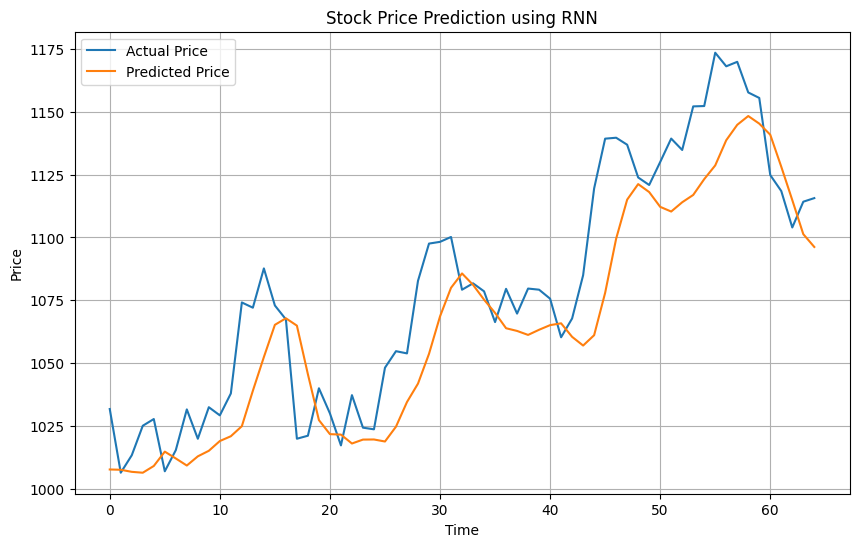

In [15]:
print('Name:  kirthick sha R ')
print('Register Number:  212224230124  ')

plt.figure(figsize=(10,6))

plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')

plt.legend()
plt.grid()

plt.show()


# ==============

In [16]:
print(f"Last Predicted Price: {predicted_prices[-1][0]:.2f}")
print(f"Last Actual Price:    {actual_prices[-1][0]:.2f}")

Last Predicted Price: 1096.23
Last Actual Price:    1115.65
